In [109]:
import pandas as pd

city_list = pd.read_csv('data/city_list.csv')
global_data = pd.read_csv('data/global_data.csv')
city_data = pd.read_csv('data/city_data.csv')

In [110]:
city_data.head()

,year,city,country,avg_temp
0,1849,Abidjan,Côte D'Ivoire,25.58
1,1850,Abidjan,Côte D'Ivoire,25.52
2,1851,Abidjan,Côte D'Ivoire,25.67
3,1852,Abidjan,Côte D'Ivoire,NaN
4,1853,Abidjan,Côte D'Ivoire,NaN


In [111]:
global_data.head()

,year,avg_temp
0,1750,8.72
1,1751,7.98
2,1752,5.78
3,1753,8.39
4,1754,8.47


In [112]:
city_list.head()

,city,country
0,Abidjan,Côte D'Ivoire
1,Abu Dhabi,United Arab Emirates
2,Abuja,Nigeria
3,Accra,Ghana
4,Adana,Turkey


In [113]:
us_cities = city_list[ city_list.country=='United States' ].city
us_cities

8           Albuquerque
10           Alexandria
19            Arlington
23              Atlanta
24               Austin
27            Baltimore
46           Birmingham
48               Boston
66            Charlotte
69              Chicago
73     Colorado Springs
74             Columbus
81               Dallas
86               Denver
87              Detroit
96              El Paso
98           Fort Worth
102              Fresno
124             Houston
128        Indianapolis
134        Jacksonville
146         Kansas City
168           Las Vegas
176          Long Beach
178         Los Angeles
179          Louisville
199             Memphis
200                Mesa
202               Miami
204           Milwaukee
205         Minneapolis
221           Nashville
224         New Orleans
225            New York
229             Oakland
230       Oklahoma City
231               Omaha
243        Philadelphia
244             Phoenix
250            Portland
262             Raleigh
271          Sac

In [114]:
city_data[ (city_data.city.isin(us_cities)) & (city_data.country != 'United States') ].groupby(['city','country']).size()

city         country       
Alexandria   Egypt             223
Birmingham   United Kingdom    271
Los Angeles  Chile             159
dtype: int64

In [115]:
city_data[ city_data.country=='United States' ].groupby(['city','country']).size()

city              country      
Albuquerque       United States    194
Alexandria        United States    271
Arlington         United States    271
Atlanta           United States    271
Austin            United States    194
Baltimore         United States    271
Birmingham        United States    271
Boston            United States    271
Charlotte         United States    271
Chicago           United States    271
Colorado Springs  United States    239
Columbus          United States    271
Dallas            United States    194
Denver            United States    239
Detroit           United States    271
El Paso           United States    189
Fort Worth        United States    194
Fresno            United States    165
Houston           United States    194
Indianapolis      United States    271
Jacksonville      United States    271
Kansas City       United States    256
Las Vegas         United States    179
Long Beach        United States    165
Los Angeles       United States 

In [116]:
city_list.groupby(['country']).size()

country
Afghanistan                            1
Albania                                1
Algeria                                1
Angola                                 1
Argentina                              2
Armenia                                1
Australia                              6
Austria                                1
Azerbaijan                             1
Bahamas                                1
Bahrain                                1
Bangladesh                             2
Belarus                                1
Belgium                                1
Bolivia                                1
Bosnia And Herzegovina                 1
Botswana                               1
Brazil                                11
Bulgaria                               1
Burkina Faso                           1
Burundi                                1
Cameroon                               1
Canada                                 6
Central African Republic               1
Chile   

In [117]:
city_list.groupby(['country']).size().reset_index(name='count').sort_values(['count'], ascending=False)[:20]

,country,count
130,United States,52
25,China,34
55,India,22
17,Brazil,11
93,Pakistan,9
101,Russia,9
79,Mexico,8
91,Nigeria,7
6,Australia,6
56,Indonesia,6


In [118]:
nola = city_data[ (city_data.city == 'New Orleans') & (city_data.country == 'United States') ]

In [119]:
nola.head()

,year,city,country,avg_temp
46085,1758,New Orleans,United States,20.87
46086,1759,New Orleans,United States,19.73
46087,1760,New Orleans,United States,9.24
46088,1761,New Orleans,United States,NaN
46089,1762,New Orleans,United States,NaN


In [120]:
nola = nola.drop(columns=['city', 'country'])
nola = nola.fillna(method='ffill')
nola['MA'] = nola['avg_temp'].rolling(window=10).mean()
nola.head(25)

,year,avg_temp,MA
46085,1758,20.87,NaN
46086,1759,19.73,NaN
46087,1760,9.24,NaN
46088,1761,9.24,NaN
46089,1762,9.24,NaN
46090,1763,9.24,NaN
46091,1764,9.24,NaN
46092,1765,9.24,NaN
46093,1766,9.24,NaN
46094,1767,9.24,11.452


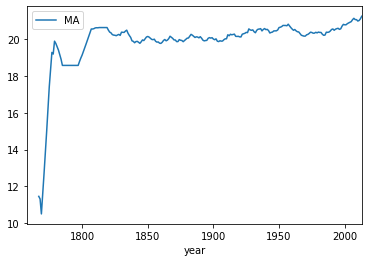

In [121]:
%matplotlib inline
lines = nola.plot.line(x='year',y='MA')

In [122]:
chi = city_data[ (city_data.city == 'Chicago') & (city_data.country == 'United States') ]
chi.head()

,year,city,country,avg_temp
15107,1743,Chicago,United States,5.44
15108,1744,Chicago,United States,11.73
15109,1745,Chicago,United States,1.80
15110,1746,Chicago,United States,NaN
15111,1747,Chicago,United States,NaN


In [123]:
chi = chi.drop(columns=['city', 'country'])
chi = chi.fillna(method='ffill')
chi['MA'] = chi['avg_temp'].rolling(window=10).mean()
chi.head(25)

,year,avg_temp,MA
15107,1743,5.44,NaN
15108,1744,11.73,NaN
15109,1745,1.80,NaN
15110,1746,1.80,NaN
15111,1747,1.80,NaN
15112,1748,1.80,NaN
15113,1749,1.80,NaN
15114,1750,10.49,NaN
15115,1751,11.19,NaN
15116,1752,4.50,5.235


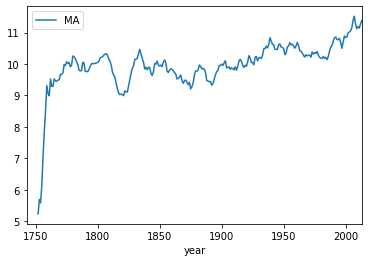

In [124]:
%matplotlib inline
lines = chi.plot.line(x='year',y='MA')

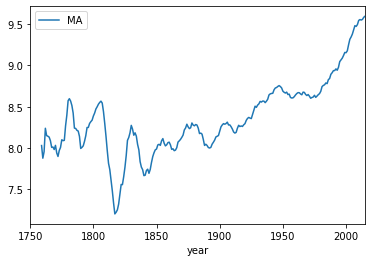

In [125]:
%matplotlib inline
global_data = global_data.fillna(method='ffill')
global_data['MA'] = global_data['avg_temp'].rolling(window=10).mean()
lines = global_data.plot.line(x='year',y='MA')

In [126]:
nola.iloc[0]

year        1758.00
avg_temp      20.87
MA              NaN
Name: 46085, dtype: float64

In [127]:
nola.iloc[-1]

year        2013.000
avg_temp      22.000
MA            21.256
Name: 46340, dtype: float64

In [128]:
chi.iloc[0]

year        1743.00
avg_temp       5.44
MA              NaN
Name: 15107, dtype: float64

In [129]:
chi.iloc[-1]

year        2013.000
avg_temp      11.590
MA            11.382
Name: 15377, dtype: float64

In [130]:
global_data.iloc[0]

year        1750.00
avg_temp       8.72
MA              NaN
Name: 0, dtype: float64

In [131]:
global_data.iloc[-1]

year        2015.000
avg_temp       9.830
MA             9.594
Name: 265, dtype: float64

In [132]:
nola = nola.drop(columns=['avg_temp'])
chi = chi.drop(columns=['avg_temp'])
global_data = global_data.drop(columns=['avg_temp'])

cbd = pd.DataFrame({'year': [y for y in range(1740,2020) ]})
cbd = cbd.merge(nola, on='year', how='left', suffixes=('','_NOLA'))\
                .merge(chi, on='year', how='left', suffixes=('','_CHI'))\
                .merge(global_data, on='year', how='left', suffixes=('','_GLOBE'))
cbd.head(20)

,year,MA,MA_CHI,MA_GLOBE
0,1740,NaN,NaN,NaN
1,1741,NaN,NaN,NaN
2,1742,NaN,NaN,NaN
3,1743,NaN,NaN,NaN
4,1744,NaN,NaN,NaN
5,1745,NaN,NaN,NaN
6,1746,NaN,NaN,NaN
7,1747,NaN,NaN,NaN
8,1748,NaN,NaN,NaN
9,1749,NaN,NaN,NaN


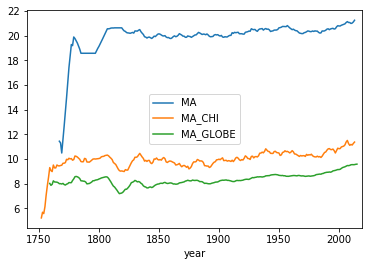

In [134]:
lines = cbd.plot.line(x='year')